In [129]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, accuracy_score
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import trange
from matplotlib import pyplot as plt

from pathlib import Path
from PIL import Image
from copy import copy

import numpy as np
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 1.29 ms (started: 2021-01-27 15:36:10 +07:00)


In [125]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

time: 1.1 ms (started: 2021-01-27 15:28:55 +07:00)


In [131]:
device = 'cuda'

train_ds = torchvision.datasets.CIFAR10(root=os.getcwd(), train=True, download=True, transform=transform)
test_ds = torchvision.datasets.CIFAR10(root=os.getcwd(), train=False, download=True, transform=transform)
train_ds.targets = torch.tensor(train_ds.targets)
train_ds.targets = train_ds.targets==2
train_ds.targets = train_ds.targets.float()

train, val = random_split(train_ds, [45000, 5000])

batch_size = 32
train_dl = DataLoader(train, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=2)
val_dl = DataLoader(val, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=2)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified
time: 1.14 s (started: 2021-01-27 15:37:52 +07:00)


Loss: 0.0000 Accuracy: 0.9387: 100%|██████████| 100/100 [15:59<00:00,  9.60s/it]


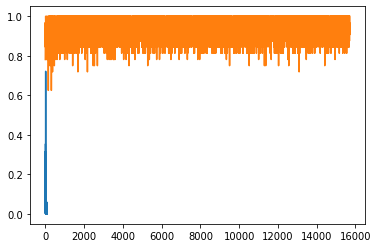

time: 16min (started: 2021-01-27 15:47:15 +07:00)


In [140]:
class BirdModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, 3),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, 3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d((2, 2))
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, 3),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d((2, 2)),
            nn.Dropout(0.05),
            nn.Flatten()
        )
        self.ln = nn.Sequential(
            nn.Linear(3200, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.ln(x)
        return x

model = BirdModel()
model.to(device)
loss_fn = nn.BCELoss()
opt = torch.optim.Adam(model.parameters())
losses = []
accuracies = []

with trange(100) as t:
    for i in t:
        for X, y in train_dl:
            y = y.unsqueeze(1)
            X, y = X.to(device), y.to(device)
            pred = model(X)
            opt.zero_grad()
            loss = loss_fn(pred, y)
            loss.backward()
            opt.step()
        for X_val, y_val in val_dl:
            X_val, y_val = X_val.to(device), y_val.to(device)
            y_preds = model(X_val)
            y_preds = y_preds >= 0.7
            y_val = y_val > 0
            acc = accuracy_score(
                y_preds.cpu().data.numpy(), 
                y_val.cpu().data.numpy(), 
            )
            accuracies.append(acc)
        losses.append(loss)
        t.set_description(f"Loss: {loss:.4f} Accuracy: {np.mean(accuracies):.4f}")
plt.plot(losses)
plt.plot(accuracies)

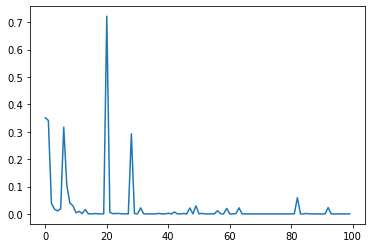

time: 92.7 ms (started: 2021-01-27 16:03:31 +07:00)


In [141]:
plt.plot(losses)

In [143]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_dl:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs >= 0.5
        y_test = labels == 2
        correct += accuracy_score(
            preds.cpu().data.numpy(), 
            y_test.cpu().data.numpy(), 
            normalize=False
        )
        total += labels.size(0)

print('Accuracy of the network on the 10000 test images: %d %%' % (correct * 100 / total))

Accuracy of the network on the 10000 test images: 93 %
time: 1.07 s (started: 2021-01-27 16:04:10 +07:00)


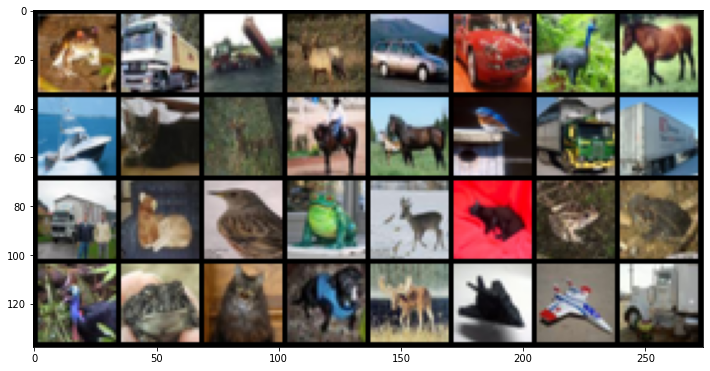

time: 210 ms (started: 2021-01-27 11:32:16 +07:00)


In [9]:
data = next(iter(train_dl))
plt.figure(figsize=(12, 16))
imshow(torchvision.utils.make_grid(data[0]))

In [148]:
model2 = copy(model)
model2.to('cpu')
for f in sorted(Path(".").glob("*.png")):
    img = np.asarray(Image.open(str(f)))
    img = transforms.ToTensor()(img)
    img = img.unsqueeze(0)
    confidence = model2(img).item()
    if confidence > 0.5:  
        print(f'{f} - Is a bird {int(confidence * 100)}%')
    else:
        print(f'{f} - Is NOT a bird {100 - int(confidence * 100)}%')

bird1.png - Is a bird 99%
bird2.png - Is a bird 100%
bird3.png - Is a bird 99%
bird4.png - Is a bird 98%
bird5.png - Is a bird 100%
not_bird1.png - Is NOT a bird 100%
not_bird2.png - Is NOT a bird 100%
not_bird3.png - Is NOT a bird 100%
not_bird4.png - Is NOT a bird 100%
not_bird5.png - Is NOT a bird 100%
time: 58.2 ms (started: 2021-01-27 16:07:02 +07:00)
